<a href="https://colab.research.google.com/github/mengtientsai/STA208_final_proj/blob/main/Fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import nltk
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
Fake_news = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Fake News Detection/Fake.csv")
True_news = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Fake News Detection/True.csv")

In [ ]:
# Fake = 1; True = 0
Fake_news["label"] = 1
True_news["label"] = 0

In [ ]:
News = Fake_news.copy()
News = News.append(True_news)
News = News[["title","label"]]

In [ ]:
# clean text
def text_cleaning(text):
  text = re.sub(r"\s+"," ", text) # remove extra spaces
  text = re.sub(r"[^a-zA-Z]"," ", text) # remove non-alphabets with spaces
  text = text.lower() # lowercase
  words = nltk.word_tokenize(text) # break into words
  newtext = []
  lemmatizer = WordNetLemmatizer()
  for word in words:
    word = lemmatizer.lemmatize(word) # group together the different inflected forms of a word
    if word not in set(stopwords.words("english")) and len(word) > 1: # remove stopwords and single character word
      newtext.append(word)
  text = " ".join(newtext)
  return text

News["title"] = News["title"].apply(text_cleaning)

In [ ]:
News.to_csv("/content/drive/My Drive/Colab Notebooks/Fake News Detection/News.csv",index=False)

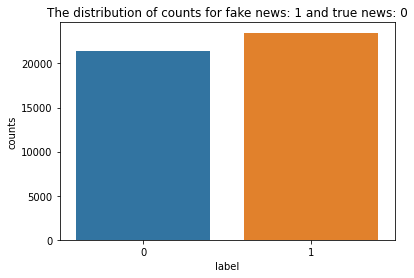

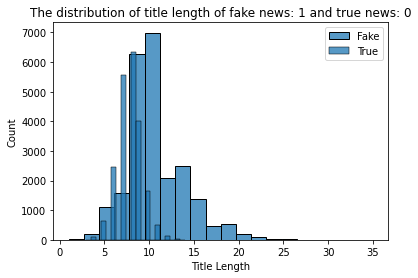

In [ ]:
# EDA
import seaborn as sns
import matplotlib.pyplot as plt

# whether the data is balanced
ax = sns.countplot(x = News["label"], alpha=1.0);
counts = News["label"].value_counts().values
#ax.bar_label(container=ax.containers[0], labels = counts)
plt.xlabel("label")
plt.ylabel("counts")
plt.title("The distribution of counts for fake news: 1 and true news: 0")
plt.savefig('/content/drive/My Drive/Colab Notebooks/Fake News Detection/Feature importances.png')
plt.show()
plt.close()

# the distribution of title length
News["title_length"] = News["title"].apply(lambda x : len(x.strip().split()))
sns.histplot(News[News["label"] == 1]["title_length"], kde=False, label="Fake", bins=20)
sns.histplot(News[News["label"] == 0]["title_length"], kde=False, label="True", bins=20)
plt.xlabel("Title Length")
plt.title("The distribution of title length of fake news: 1 and true news: 0")
plt.legend()
plt.show()

In [ ]:
# split data for training and test
from sklearn.model_selection import train_test_split
X = News["title"].values.tolist()
y = News["label"].values
# 70%:30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

In [ ]:
# Word Embeddings TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train_TI = vectorizer.fit_transform(X_train)
X_test_TI = vectorizer.transform(X_test)

In [ ]:
# Chi-square test to select variables that are dependent to the label
from sklearn.feature_selection import chi2

X_features = vectorizer.get_feature_names_out()

_, p = chi2(X_train_TI, y_train)
features = pd.DataFrame({"feature":X_features, "score":p})
features = features[features["score"]<0.05]

X_features = features["feature"].tolist()

In [ ]:
# keep selected features
vectorizer = TfidfVectorizer(vocabulary = X_features)
X_train_TI = vectorizer.fit_transform(X_train)
X_test_TI = vectorizer.transform(X_test)

In [ ]:
# final X train and test
import scipy.sparse

featureslist = vectorizer.vocabulary_
X_train_final = pd.DataFrame.sparse.from_spmatrix(X_train_TI, columns = featureslist)
X_test_final = pd.DataFrame.sparse.from_spmatrix(X_test_TI, columns = featureslist)

In [ ]:
# save X to csv
X_train_final.to_csv("/content/drive/My Drive/Colab Notebooks/Fake News Detection/X_train_TI.csv",index=False)
X_test_final.to_csv("/content/drive/My Drive/Colab Notebooks/Fake News Detection/X_test_TI.csv",index=False)

In [ ]:
# save y to csv
pd.DataFrame(y_train).to_csv("/content/drive/My Drive/Colab Notebooks/Fake News Detection/y_train.csv",index=False)
pd.DataFrame(y_test).to_csv("/content/drive/My Drive/Colab Notebooks/Fake News Detection/y_test.csv",index=False)

Random Forest

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

In [12]:
# read data
X_train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Fake News Detection/X_train_TI.csv")
X_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Fake News Detection/X_test_TI.csv")
y_train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Fake News Detection/y_train.csv")
y_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Fake News Detection/y_test.csv")

In [ ]:
# parameter optimization using grid search
rf_opt = GridSearchCV(estimator = RandomForestClassifier(random_state = 0, n_jobs = -1),
                      param_grid = {"n_estimators": [100, 200, 300, 400, 500],
                                    "criterion": ["gini", "entropy"]},
                      scoring = "accuracy", cv = 5, n_jobs = -1, refit=False)

rf_opt.fit(X_train, y_train)
# report the best result
print(rf_opt.best_score_)
print(rf_opt.best_params_)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.9214715328807106
{'criterion': 'entropy', 'n_estimators': 300}


In [ ]:
# fit the model with best parameteres
t1 = time()
rf = RandomForestClassifier(n_estimators = 300, criterion = "entropy", n_jobs = -1).fit(X_train, y_train.values.ravel())
t2 = time()-t1
# predict
t3 = time()
y_pred_rf = rf.predict(X_test)
t4 = time()-t3
print(f" Training time of Random Forest :{t2}")
print(f" Prediction time of Random Forest :{t4}")
# save it to csv
#pd.DataFrame(y_pred_rf).to_csv("/content/drive/My Drive/Colab Notebooks/Fake News Detection/y_pred_RF.csv",index=False)

 Training time of Random Forest :163.95865774154663
 Prediction time of Random Forest :3.438601493835449


 Accuracy of Random Forest : 92.97999999999999 %
 Classification Report of Random Forest : 
               precision    recall  f1-score   support

           0       0.92      0.93      0.93      6425
           1       0.94      0.93      0.93      7045

    accuracy                           0.93     13470
   macro avg       0.93      0.93      0.93     13470
weighted avg       0.93      0.93      0.93     13470



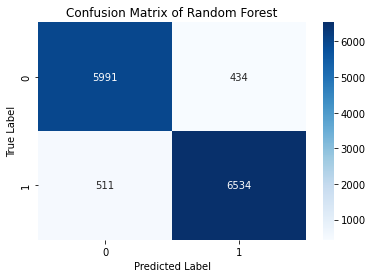

In [ ]:
# Evaluate the model
print(f" Accuracy of Random Forest : {np.round(accuracy_score(y_test, y_pred_rf), 4) * 100} %")
print(f" Classification Report of Random Forest : \n {classification_report(y_test, y_pred_rf)}")
# Plot the confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix of Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
# Save the plot
plt.savefig('/content/drive/My Drive/Colab Notebooks/Fake News Detection/Confusion Matrix of Random Forest.png')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve
# get the probabilities for each class
y_prob_RF = rf.predict_proba(X_test)
# get fpr and tpr
fpr0_RF, tpr0_RF, _ = roc_curve(y_test, y_prob_RF[:,0])
fpr1_RF, tpr1_RF, _ = roc_curve(y_test, y_prob_RF[:,1])
# get precision and recall
precision0_RF, recall0_RF, _ = precision_recall_curve(y_test, y_prob_RF[:,0])
precision1_RF, recall1_RF, _ = precision_recall_curve(y_test, y_prob_RF[:,1])

Since we want to detection fake news which is label 1, it is enough to plot ROC and PR curves for Fake label.

No handles with labels found to put in legend.


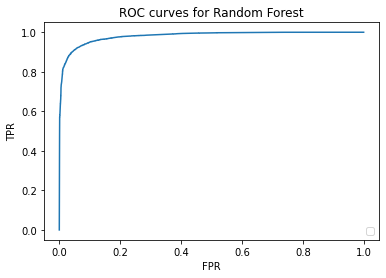

In [ ]:
plt.plot(fpr1_RF, tpr1_RF)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC curves for Random Forest")
plt.legend(loc="lower right")
plt.show()
plt.close()

In [ ]:
# save data to csv
ROC_RF = pd.DataFrame({'fpr_RF': fpr1_RF, 'tpr_RF':tpr1_RF})
ROC_RF.to_csv("/content/drive/My Drive/Colab Notebooks/Fake News Detection/ROC_RF.csv",index=False)
PR_RF = pd.DataFrame({'precision_RF':precision1_RF, 'recall_RF':recall1_RF})
PR_RF.to_csv("/content/drive/My Drive/Colab Notebooks/Fake News Detection/PR_RF.csv",index=False)

Plot confusion matrix

In [18]:
# read predict labels
y_pred_svm = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Fake News Detection/y_pred_svm.csv")
y_pred_LR = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Fake News Detection/y_pred_LR.csv")
y_pred_RF = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Fake News Detection/y_pred_RF.csv")

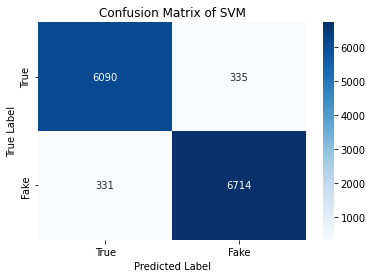

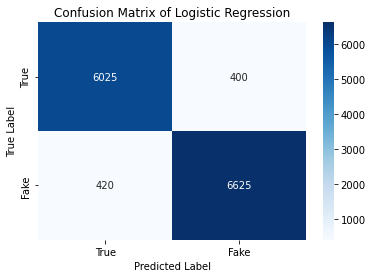

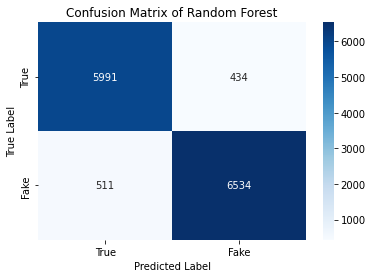

In [19]:
Label = ["True","Fake"]
# svm
cm_SVM = confusion_matrix(y_test, y_pred_svm)
cm_SVM_df = pd.DataFrame(cm_SVM, index = Label, columns = Label)
sns.heatmap(cm_SVM_df, annot=True, fmt="d", cmap = "Blues")
plt.title('Confusion Matrix of SVM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
# Save the plot
plt.savefig('/content/drive/My Drive/Colab Notebooks/Fake News Detection/Confusion Matrix of SVM.png',bbox_inches = "tight")
plt.show()
Label = ["True","Fake"]
# logitic regression
cm_LR = confusion_matrix(y_test, y_pred_LR)
cm_LR_df = pd.DataFrame(cm_LR, index = Label, columns = Label)
sns.heatmap(cm_LR_df, annot=True, fmt="d", cmap = "Blues")
plt.title('Confusion Matrix of Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
# Save the plot
plt.savefig('/content/drive/My Drive/Colab Notebooks/Fake News Detection/Confusion Matrix of Logistic Regression.png',bbox_inches = "tight")
plt.show()

# random forest
cm_RF = confusion_matrix(y_test, y_pred_RF)
cm_RF_df = pd.DataFrame(cm_RF, index = Label, columns = Label)
sns.heatmap(cm_RF_df, annot=True, fmt="d", cmap = "Blues")
plt.title('Confusion Matrix of Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
# Save the plot
plt.savefig('/content/drive/My Drive/Colab Notebooks/Fake News Detection/Confusion Matrix of Random Forest.png',bbox_inches = "tight")
plt.show()